<h2>Por que XGBoost?</h2>

<h3>1 - Desempenho</h3>
<p>Conhecido por sua capacidade de fornecer um desempenho excepcional em uma ampla gama de conjuntos de dados. Ele é altamente otimizado e eficiente, o que o torna uma escolha ideal para lidar com grandes conjuntos de dados com muitas características.</p>

<h3>2 - Regularização</h3>
<p>Oferece várias técnicas de regularização, como regularização L1 e L2, que ajudam a evitar overfitting e melhorar a generalização do modelo. Isso é especialmente importante em análise de sentimentos, onde o sobreajuste pode ser um problema comum devido à complexidade e subjetividade dos dados.</p>

<h3>3 - Flexibilidade</h3>
<p>Suporta uma variedade de funções de perda e métricas de avaliação, permitindo que você ajuste o modelo de acordo com os requisitos específicos do problema de análise de sentimentos. Além disso, ele pode ser facilmente integrado com outras bibliotecas e ferramentas populares de ciência de dados.</p>

<h3>4 - Interpretabilidade</h3>
<p>Embora seja um modelo complexo, XGBoost oferece certa interpretabilidade. Você pode visualizar a importância das características, o que ajuda a entender quais palavras ou características estão contribuindo mais para as previsões de sentimento.</p>

In [19]:
# Bibliotecas usadas para formatação dos dados e treino do modelo
import re
import string
import unicodedata
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from joblib import dump
from tabulate import tabulate
import xgboost as xgb

# Baixa recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h2>Removendo itens irrelevantes</h2>
<p>O modelo é feito para analisar sentimentos sobre compras nas lojas Americanas. Com isso em mente removemos tudo que não é de valor e linhas vazias do dado para o modelo.</p>

In [5]:
# Carrega o conjunto de dados
dataset = pd.read_csv("C:\\fatec\\B2W-Reviews01\\B2W-Reviews01.csv")

# Mostra o tamanho do dataset original
print("Tamanho do dataset original:", dataset.shape[0], "\n")

# Remove linhas com valores em branco
dataset = dataset.dropna(subset=['review_text', 'overall_rating'])

# Mostra o tamanho do dataset alterado
print("Tamanho do dataset alterado:", dataset.shape[0], "\n")


Tamanho do dataset original: 132373 

Tamanho do dataset alterado: 129098 



C:\Users\augus\AppData\Local\Temp\ipykernel_5504\3311458984.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("C:\\fatec\\B2W-Reviews01\\B2W-Reviews01.csv")


<h2>Separando por Categoria</h2>
<p>O modelo precisa receber 3 valores, sendo 0, 1 e 2. Aqui estamos criando uma nova coluna no csv com esse valores tomando de base a avaliação dos clientes, onde notas menores a 3 são 0 (negativo) iguais a 3 são 1 (neutro) e maiores que 3 são 2 (positivo).</p>

In [6]:
# Cria uma nova coluna para classificar entre comentários positivos(2), negativos(0) ou neutros(1) com base na nota:
dataset['feeling'] = np.where(dataset['overall_rating'] < 3, 0, np.where(dataset['overall_rating'] == 3, 1, 2))

# Mostra os primeiros registros do dataset
print("Primeiros registros do dataset:")
print(tabulate(dataset.head(20), headers='keys', tablefmt='pipe'))


Primeiros registros do dataset:
|    | submission_date     | reviewer_id                                                      |   product_id | product_name                                                                                                                   | product_brand   | site_category_lv1       | site_category_lv2             | review_title                     |   overall_rating | recommend_to_a_friend   | review_text                                                                                                                                                                                                                                                         |   reviewer_birth_year | reviewer_gender   | reviewer_state   |   feeling |
|---:|:--------------------|:-----------------------------------------------------------------|-------------:|:----------------------------------------------------------------------------------------------------------------------------

<h2>Formatação do texto</h2>
<p>Agora temos as métricas para o modelo aprender a natureza de um comentário, porem ainda precisamos fazer mais alterações no texto dos clientes para remover palavras irrelevantes e distribuir o valor entre palavras iguais, escrito difente ou incorreto, e sinonimas.</p>

In [7]:
# Pré-processamento dos dados
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('portuguese'))

preprocessed_texts = []  # Lista para armazenar os textos pré-processados

# Itera sobre cada texto no dataset para pré-processamento
for text in dataset['review_text']:
    if isinstance(text, str):  # Verifica se o texto é uma string
        # Converter para minúsculas
        text = text.lower()
        # Remover acentos
        text = ''.join(char for char in unicodedata.normalize('NFKD', text) if unicodedata.category(char) != 'Mn')
        # Remover números usando expressão regular
        text = re.sub(r'\d+', '', text)
        # Remover caracteres especiais (incluindo emojis)
        text = re.sub(r'[^\w\s]', '', text)
        # Remover pontuação
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remover espaços extras
        text = re.sub(r'\s+', ' ', text).strip()
        # Tokenização
        tokens = word_tokenize(text)
        # Lematização e remoção de stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word.lower() not in stop_words]
        # Juntar tokens em texto novamente
        preprocessed_text = ' '.join(tokens)
        preprocessed_texts.append(preprocessed_text)  # Adicionar texto pré-processado à lista
    else:
        preprocessed_texts.append("")

# Atualiza o DataFrame com os textos pré-processados
dataset['review_text'] = preprocessed_texts

# Mostra o dataset após o pré-processamento
print("\nDataset após pré-processamento:")
print(tabulate(dataset.head(20), headers='keys', tablefmt='pipe'))



Dataset após pré-processamento:
|    | submission_date     | reviewer_id                                                      |   product_id | product_name                                                                                                                   | product_brand   | site_category_lv1       | site_category_lv2             | review_title                     |   overall_rating | recommend_to_a_friend   | review_text                                                                                                                                                                                        |   reviewer_birth_year | reviewer_gender   | reviewer_state   |   feeling |
|---:|:--------------------|:-----------------------------------------------------------------|-------------:|:-------------------------------------------------------------------------------------------------------------------------------|:----------------|:------------------------|:---------------

In [8]:
# Separar os dados em features (X) e target (Y)
X = dataset['review_text'].values
Y = dataset['feeling'].values


<h2>Vetorizar</h2>
<p>Assim que o texto estiver pronto precisamos vetorizalo, transformalo em números, pois é o formato em que o modelo entende e consegue fazer a analise.</p>

<p>Nos também estamos usando uma técnica para melhorar o resultado do modelo, onde ele analisa cada palavra individualmente, a junção de duas e junção três palavras para identificar a classe.</p>

In [9]:
# Criar um objeto CountVectorizer com N-grams
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))  # Considera unigramas, bigramas e trigramas

# Vetorizar os dados de texto com N-grams
X_ngrams = ngram_vectorizer.fit_transform(X)


<h2>Treino e Teste</h2>
<p>Para treinar e testar o modelo nós usamos validação cruzada, onde conseguimos estimar o desempenho de um modelo em dados não vistos. Ele divide os dados em 5 partes iguais, treina o modelo em 4 partes e testa em uma parte, repetindo o processo para cada parte.</p>


In [10]:
# Criar uma instância do modelo XGBoost
xgboost = xgb.XGBClassifier()

# Especificar o número de folds para a validação cruzada
num_folds = 5

# Criar um objeto StratifiedKFold para a validação cruzada estratificada
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lista para armazenar as pontuações de acurácia de cada fold
accuracy_scores = []

# Realizar a validação cruzada
for train_index, test_index in kfold.split(X_ngrams, Y):
    X_train, X_test = X_ngrams[train_index], X_ngrams[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Treinar o modelo XGBoost
    xgboost.fit(X_train, Y_train)
    
    # Avaliar o modelo com acurácia
    accuracy = xgboost.score(X_test, Y_test)
    accuracy_scores.append(accuracy)


Acurácia média: 0.8182543626039452
Desvio padrão da acurácia: 0.0017199851869484867


<h2>Acurácia</h2>
<p>No final, ele calcula a média e o desvio padrão das métricas de avaliação em todos os folds.</p>

In [20]:
# Calcular a média e o desvio padrão das pontuações de acurácia
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Exibir os resultados da validação cruzada
print("Acurácia média:", mean_accuracy)
print("Desvio padrão da acurácia:", std_accuracy)

Acurácia média: 0.8182543626039452
Desvio padrão da acurácia: 0.0017199851869484867


In [11]:
# Prever as classes para os dados de teste
Y_pred = xgboost.predict(X_test)

# Criar um DataFrame com as previsões e as verdadeiras classes de "feeling"
df_results = pd.DataFrame({'Feeling_Predicted': Y_pred, 'Feeling_True': Y_test})
# Substituindo os valores
df_results['Feeling_Predicted'] = df_results['Feeling_Predicted'].replace({0: 'negativo', 1: 'neutro', 2: 'positivo'})
df_results['Feeling_True'] = df_results['Feeling_True'].replace({0: 'negativo', 1: 'neutro', 2: 'positivo'})

# Mostrar os resultados
print("\nResultados de 'feeling' após o treinamento do modelo:")
print(tabulate(df_results.head(20)))  # Exibir os 20 primeiros registros



Resultados de 'feeling' após o treinamento do modelo:
--  --------  --------
 0  negativo  positivo
 1  positivo  positivo
 2  positivo  positivo
 3  positivo  positivo
 4  negativo  negativo
 5  positivo  negativo
 6  positivo  positivo
 7  positivo  positivo
 8  positivo  positivo
 9  positivo  positivo
10  positivo  positivo
11  positivo  positivo
12  positivo  positivo
13  negativo  negativo
14  positivo  positivo
15  positivo  positivo
16  positivo  positivo
17  positivo  positivo
18  positivo  neutro
19  positivo  positivo
--  --------  --------


<h2>Matriz de Confusão</h2>
<p>A Matriz serve para termos uma visualização melhor de quanto o modelo acertou e errou em cada caso, assim podemos fazer melhorias mais precisas.</p>

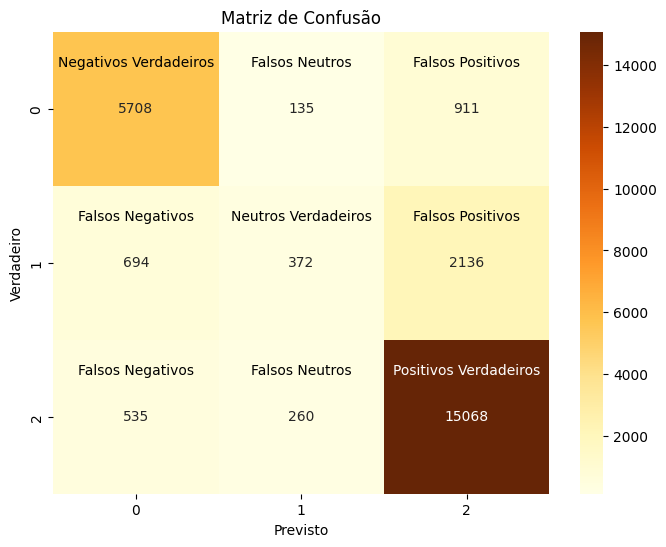

In [18]:
cm = confusion_matrix(Y_pred, Y_test)

# Plot da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, cmap='YlOrBr', fmt='g')

# Adicionando legenda
plt.text(0.5, 0.2, 'Negativos Verdadeiros', color='black', ha='center', va='center')
plt.text(1.5, 0.2, 'Falsos Neutros', color='black', ha='center', va='center')
plt.text(2.5, 0.2, 'Falsos Positivos', color='black', ha='center', va='center')

plt.text(0.5, 1.2, 'Falsos Negativos', color='black', ha='center', va='center')
plt.text(1.5, 1.2, 'Neutros Verdadeiros', color='black', ha='center', va='center')
plt.text(2.5, 1.2, 'Falsos Positivos', color='black', ha='center', va='center')

plt.text(0.5, 2.2, 'Falsos Negativos', color='black', ha='center', va='center')
plt.text(1.5, 2.2, 'Falsos Neutros', color='black', ha='center', va='center')
plt.text(2.5, 2.2, 'Positivos Verdadeiros', color='white', ha='center', va='center')

# Definindo rótulos dos eixos
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')

plt.show()



<h2>Precisão</h2>
<p>Mede a qualidade das previsões positivas do modelo. Se a precisão é alta, significa que o modelo comete poucos erros</p>

<h2>Recall</h2>
<p>Mede a capacidade do modelo de encontrar todos os exemplos. Se o recall é alto, significa que o modelo está detectando a maioria dos exemplos.</p>

<h2>F1-score</h2>
<p>É a média harmônica da precisão e do recall. Ele penaliza modelos que têm um desequilíbrio entre precisão e recall. Se o F1-score é alto, isso significa que o modelo tem um bom equilíbrio entre precisão e recall.</p>

In [13]:
# Calcular a precisão para cada classe, mede a precisão das previsões
precision_negativo = precision_score(Y_test, Y_pred, average=None)[0]
precision_neutro = precision_score(Y_test, Y_pred, average=None)[1]
precision_positivo = precision_score(Y_test, Y_pred, average=None)[2]

# Calcular o recall para cada classe, mede a capacidade do modelo de encontrar todos os exemplos
recall_negativo = recall_score(Y_test, Y_pred, average=None)[0]
recall_neutro = recall_score(Y_test, Y_pred, average=None)[1]
recall_positivo = recall_score(Y_test, Y_pred, average=None)[2]

# Calcular o F1-score para cada classe, média harmônica da precisão e do recall
f1_negativo = f1_score(Y_test, Y_pred, average=None)[0]
f1_neutro = f1_score(Y_test, Y_pred, average=None)[1]
f1_positivo = f1_score(Y_test, Y_pred, average=None)[2]

# Exibir os resultados
print("Precisão para a classe Negativo:", precision_negativo)
print("Precisão para a classe Neutro:", precision_neutro)
print("Precisão para a classe Positivo:", precision_positivo)

print("\nRecall para a classe Negativo:", recall_negativo)
print("Recall para a classe Neutro:", recall_neutro)
print("Recall para a classe Positivo:", recall_positivo)

print("\nF1-score para a classe Negativo:", f1_negativo)
print("F1-score para a classe Neutro:", f1_neutro)
print("F1-score para a classe Positivo:", f1_positivo)


Precisão para a classe Negativo: 0.8228340781317572
Precisão para a classe Neutro: 0.485006518904824
Precisão para a classe Positivo: 0.8317968534363787

Recall para a classe Negativo: 0.8451288125555226
Recall para a classe Neutro: 0.11617738913179262
Recall para a classe Positivo: 0.949883376410515

F1-score para a classe Negativo: 0.8338324446716822
F1-score para a classe Neutro: 0.1874527588813303
F1-score para a classe Positivo: 0.8869268350108894


<h2>Curva de ROC</h2>
<p>a Curva ROC e a AUC-ROC são ferramentas visuais para entender quão bem o seu modelo de classificação está separando as diferentes classes. Quanto mais próxima a curva estiver do canto superior esquerdo e maior for a AUC-ROC, melhor é o desempenho do modelo.</p>

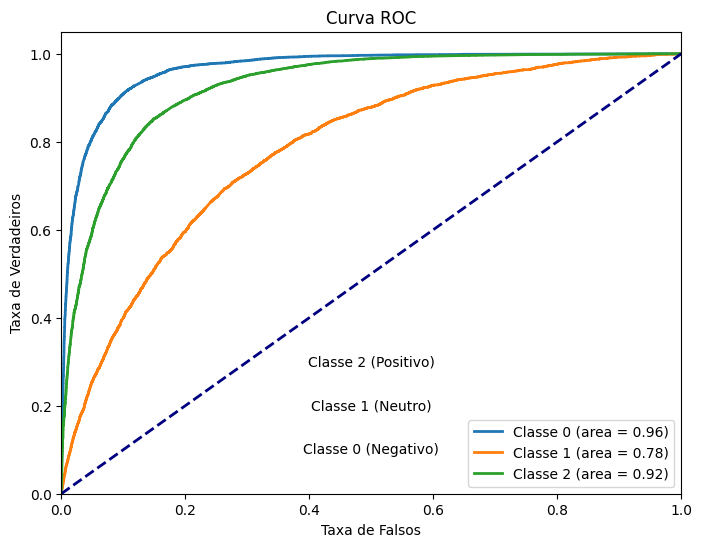

In [14]:
# Calcule as pontuações de probabilidade previstas para cada classe
y_scores = xgboost.predict_proba(X_test)

# Calcule a Curva ROC e a AUC-ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(xgboost.classes_)):
    fpr[i], tpr[i], _ = roc_curve(Y_test, y_scores[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot das Curvas ROC para cada classe com legenda
plt.figure(figsize=(8, 6))
for i in range(len(xgboost.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label='Classe {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos')
plt.ylabel('Taxa de Verdadeiros')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Adicionando legenda personalizada
class_legend = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}
for i in range(len(xgboost.classes_)):
    plt.text(0.5, 0.1 + i * 0.1, f"Classe {i} ({class_legend[i]})", color='black', ha='center', va='center')

plt.show()


In [15]:
# Salvar o modelo e o vetorizador em um único arquivo, no mesmo diretório deste notebook
dump((xgboost, ngram_vectorizer), 'modelo_xg_boost.joblib')


['modelo_xg_boost.joblib']